<a href="https://colab.research.google.com/github/maro-amoeba/FruitsRecognitionCamera/blob/master/Fruits_Recognition_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに。

フルーツの種類を画像分類できる様に深層学習モデルを構築します。  
データは以下から取得します。(MIT)  
https://www.kaggle.com/moltean/fruits  

現在もデータセットは更新されており、2019年01月03日時点ではクラス数は92です。  
1月7日時点で93になりました。

# Google Driveマウント

モデルの保存先として利用する為、用意します。

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


以下のpathがマウントしたgdriveのディレクトリになっています  
/gdrive/My Drive/

私は以下のpathに学習モデルデータの保存をします。  
/content/gdrive/My Drive/Mount Point

In [0]:
import os

# モデルのsaveフォルダ
base_save_dir = '/content/gdrive/My Drive/Mount Point/'
if not os.path.exists(base_save_dir):
    os.makedirs(base_save_dir)

# Kaggle Data download

## kaggle.json upload on note

左上のメニューから追加するか、以下のセルを実行してインスタンスのドライブにアップ

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q --upgrade pip
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 66 Jan  8 01:19 kaggle.json


## Dataset download

インスタンスのドライブにダウンロードします。

In [0]:
!kaggle datasets download -d moltean/fruits

 98% 634M/650M [00:12<00:00, 37.0MB/s]
100% 650M/650M [00:12<00:00, 55.3MB/s]


In [0]:
!unzip -q fruits.zip
!rm fruits.zip

In [0]:
ls

fruits-360/  fruits.h5  gdrive/  kaggle.json  sample_data/


# Keras model creating

Written date データセットVersion: 2019.01.03.0  
92クラスの果物のクラス分類のために、CNNを構築します。  
データセットでは、合計63261枚の画像が2つのフォルダに分割されています。  
トレーニングセットの47285画像とテストセットは15873枚の画像です。  
使用するイメージのサイズは100 * 100です。  

In [0]:
# ファイル名とそれぞれのターゲットラベルをnumpy配列にロードします
import os
import glob
from tqdm import tqdm
import numpy as np
import cv2

train_path = "fruits-360/Training/*"
test_path = "fruits-360/Test/*"

def img2np(folder_path):
    imgs = []
    indices = []
    labels = []
    for dir_path in tqdm(glob.glob(folder_path)):
        img_label = dir_path.split("/")[-1]
        for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
            img_tmp = cv2.imread(img_path)
            img_tmp = cv2.resize(img_tmp, (100, 100)) # Default img size ==>(100, 100)
            img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
            imgs.append(img_tmp)            
            labels.append(img_label)
            
    imgs = np.array(imgs)
    labels = np.array(labels)
    label_to_id = {v : k for k, v in enumerate(np.unique(labels))}
    indices = np.array([label_to_id[i] for i in labels])
        
    return imgs, indices, labels

x_train, y_train, target_labels = img2np(train_path)
print('train Loading complete!')
x_test, y_test, _ = img2np(test_path)
print('test Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

  2%|▏         | 2/93 [00:00<00:05, 16.98it/s]

train Loading complete!


100%|██████████| 93/93 [00:05<00:00, 15.60it/s]


test Loading complete!
Training set size :  47585
Testing set size :  15975


In [0]:
# クラスの数を確認
num_of_classes = len(np.unique(y_train))
num_of_classes

93

In [0]:
# クラスをone-hot表現に変換
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_of_classes)
y_test = np_utils.to_categorical(y_test, num_of_classes)

Using TensorFlow backend.


In [0]:
# テストデータのバリデーションを用意
x_test, x_valid = x_test[7000:], x_test[:7000]
y_test, y_vaild = y_test[7000:], y_test[:7000]
print('Vaildation X : ', x_valid.shape)
print('Vaildation y :', y_vaild.shape)
print('Test X : ', x_test.shape)
print('Test y : ', y_test.shape)

Vaildation X :  (7000, 100, 100, 3)
Vaildation y : (7000, 93)
Test X :  (8975, 100, 100, 3)
Test y :  (8975, 93)


In [0]:
# すべてのピクセル値[0-255]の値を[0.0-1.0]にリスケール
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

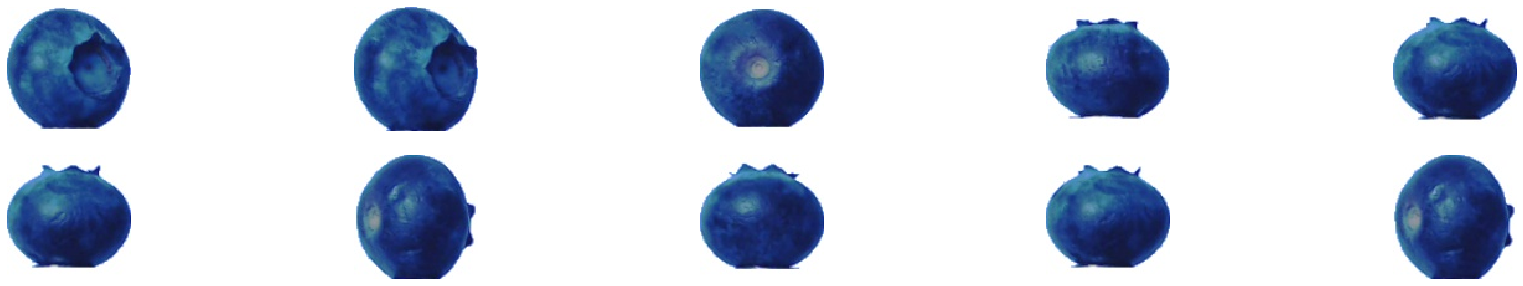

In [0]:
# 最初のトレーニングに使う10の画像をみてみましょう
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [0]:
# CNNモデルの構築

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape=(100, 100, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(150, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_of_classes, activation = 'softmax'))

# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, epsilon=1e-8, decay=1e-4),
              metrics=['accuracy'])

データの拡張を行います。  

ポイントだと思うところは、縮小です。  
実際に撮影した場合はフルーツがカメラの画像に一律のサイズで写るとは考えずらく、  
パラメータは広めに設定をしました。

In [0]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.8, 1.4])

In [0]:
from keras.callbacks import ModelCheckpoint

batch_size = 128
nb_epoch = 4

checkpointer = ModelCheckpoint(filepath = 'fruits.h5', verbose = 0, save_best_only = True)

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train) / batch_size,
                              validation_data=(x_valid, y_vaild),
#                               validation_data=datagen.flow(x_valid, y_vaild, batch_size=batch_size),
#                               validation_steps=len(x_valid) / batch_size,
                              epochs=nb_epoch,
                              callbacks = [checkpointer])

Epoch 1/4
372/371 [==============================] - 140s 376ms/step - loss: 1.4351 - acc: 0.6674 - val_loss: 0.1515 - val_acc: 0.9774
Epoch 2/4
372/371 [==============================] - 134s 360ms/step - loss: 0.2390 - acc: 0.9488 - val_loss: 0.1253 - val_acc: 0.9656
Epoch 3/4
372/371 [==============================] - 137s 368ms/step - loss: 0.1205 - acc: 0.9724 - val_loss: 0.0959 - val_acc: 0.9724
Epoch 4/4
372/371 [==============================] - 137s 368ms/step - loss: 0.0858 - acc: 0.9785 - val_loss: 0.0324 - val_acc: 0.9906


In [0]:
# from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# batch_size = 128
# nb_epoch = 4

# start_lr = 0.001
# stop_lr = 0.00001
# learning_rates = np.linspace(start_lr, stop_lr, nb_epoch)
# change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]), verbose=0)

# checkpointer = ModelCheckpoint(filepath = 'fruits.hdf5', monitor='val_acc',  verbose = 0, save_best_only = True)

# history = model.fit(x_train,y_train,
#                     batch_size = batch_size,
#                     epochs=nb_epoch,
#                     validation_data=(x_valid, y_vaild),
#                     callbacks = [change_lr, checkpointer]
#                    )

Train on 47285 samples, validate on 7000 samples
Epoch 1/4
47285/47285 [==============================] - 38s 801us/step - loss: 0.7308 - acc: 0.8710 - val_loss: 0.0649 - val_acc: 0.9883
Epoch 2/4
47285/47285 [==============================] - 34s 716us/step - loss: 0.0560 - acc: 0.9966 - val_loss: 0.0239 - val_acc: 0.9960
Epoch 3/4
47285/47285 [==============================] - 34s 714us/step - loss: 0.0280 - acc: 0.9985 - val_loss: 0.0189 - val_acc: 0.9980
Epoch 4/4
47285/47285 [==============================] - 34s 713us/step - loss: 0.0222 - acc: 0.9989 - val_loss: 0.0177 - val_acc: 0.9976


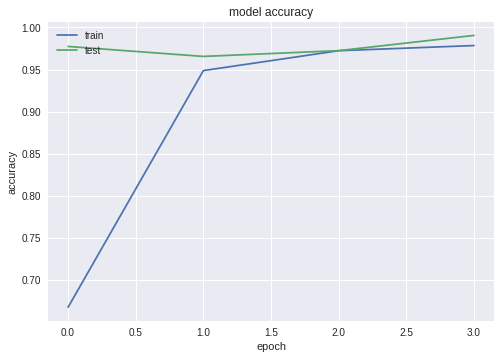

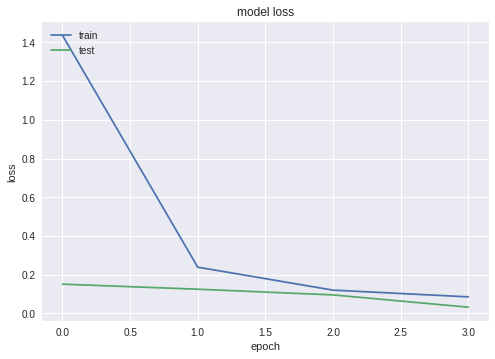

In [0]:
# trainとtestのaccとlossのグラフを表示
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [0]:
# もっとも良い検証精度をもたらした重みをロードします
model.load_weights('fruits.h5')

In [0]:
# ロードした重みによるスコアを表示します。
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9817270195318132


In [0]:
# モデルの最終的なアーキテクチャをgdriveに保存します
keras_model_path = base_save_dir + 'fruits_model.h5'
model.save(keras_model_path)

In [0]:
# targetのクラスをテキストとして保存します
target_labels_path = base_save_dir + 'fruits_labels.txt'
target_labels_list = np.unique(target_labels).tolist()

f = open(target_labels_path, 'w')
for x in target_labels_list:
    f.write(str(x) + "\n")
f.close()

学習のポイントは、  
オプティマイザーはAdam(特に画像認識で実績が多く、私は最初に試します)  
バッチノーマライズレイヤーを加えること
その上でドロップアウトを慎重に調整すること(実験を繰り返します)   

(kernel_initializerは今回あまり変化を起こさない印象でした。)  

また、もしepoch数の多いタスクでしたらEarlyStoppingを利用していたと思います。

これらの実験により、
約99パーセントのバリデーションスコアを出せています  
他のカーネルよりエポック数が少なく精度が高いのが特徴かなと思います。  

# keras to tensorflow mobile モデル

code adapted from...
https://github.com/icchi-h/keras_to_tensorflow/blob/master/keras_to_tensorflow.py  

このノートブックに適応するよう書き換えています。

In [0]:
from keras.models import load_model
import tensorflow as tf
import os
import os.path as osp
from keras import backend as K

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io


# Set parameters
keras_model_path = keras_model_path
num_output = 1
write_graph_def_ascii_flag = True
prefix_output_node_names_of_final_network = 'output_node'
keras_model_name = keras_model_path.split("/")[-1].split(".")[0]
tensorflow_graph_name = keras_model_name + '.pb'

# 出力ディレクトリの準備
output_dir = base_save_dir
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)


# Load keras model and rename output
K.set_learning_phase(0)
keras_model = load_model(keras_model_path)

pred = [None]*num_output
pred_node_names = [None]*num_output
for i in range(num_output):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(keras_model.output[i], name=pred_node_names[i])
print('Output nodes names: ', pred_node_names)


# [optional] write graph definition in ascii
sess = K.get_session()
if write_graph_def_ascii_flag:
    f = tensorflow_graph_name + '.ascii'
    tf.train.write_graph(sess.graph.as_graph_def(), output_dir, f, as_text=True)
    print('Saved the graph definition: ', osp.join(output_dir, f))


# convert variables to constants and save
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_dir, tensorflow_graph_name, as_text=False)

print('Saved the TensorFlow graph: ', osp.join(output_dir, tensorflow_graph_name))

Output nodes names:  ['output_node0']
Saved the graph definition:  /content/gdrive/My Drive/Mount Point/fruits_model.pb.ascii
INFO:tensorflow:Froze 32 variables.
INFO:tensorflow:Converted 32 variables to const ops.
Saved the TensorFlow graph:  /content/gdrive/My Drive/Mount Point/fruits_model.pb


___
出力でプリントされている『output_node0』は  
のちにandroid用tensorflowを利用するさい引き渡す重要なパラメータの一つです。

これらの重要なパラメータの詳しくは、pbファイルと同じディレクトリに保存される  
.asciiファイルに記載されています。

# keras to tensorflow lite モデル

pbファイルでのスマホによる認識は2019年の早いうちに廃止になる為、  
liteでのデータも作成します。  
むしろこちらのデータを用いて開発をすることになるでしょう。

In [0]:
import tensorflow as tf

converter = tf.contrib.lite.TFLiteConverter.from_keras_model_file(keras_model_path)
tflite_model = converter.convert()

tflite_model_path = base_save_dir + 'fruits_model.tflite'
open(tflite_model_path, "wb").write(tflite_model)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
INFO:tensorflow:Froze 32 variables.
INFO:tensorflow:Converted 32 variables to const ops.


3218584